### Three Phases MB & MF

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

# Training parameters
nb_steps = 150

def run_simulation_mf(seed):
    # Tracking variables for rewards
    cumulative_rewards_mf = [0]
    step_rewards_mf = []
    average_sum_mf = []
    np.random.seed(seed)
    
    # Learning parameters
    alpha = 0.1
    gamma = 0.9
    epsilon = 0.9
    epsilon_decay = 0.01
    epsilon_final = 0.01
    
    # Total number of States and Actions
    nb_states = 3  # S0, S1, S2
    nb_actions = 2  # Left, Right
    
    # Initialize transition and reward matrices for the smaller state space
    MDP_T = np.zeros((nb_states, nb_states, nb_actions))
    MDP_R = np.zeros((nb_states, nb_actions))
    
    # Define state transitions for S0
    MDP_T[0, 1, 0] = 0.7  # From S0 to S1 with Left action
    MDP_T[0, 2, 0] = 0.3  
    MDP_T[0, 2, 1] = 0.7  # From S0 to S2 with Right action
    MDP_T[0, 1, 1] = 0.3  
    
    # Since from S1 and S2 we go back to S0 with probability 1, we only update those
    MDP_T[1, 0, 0] = 1.0  # From S1 to S0 with Left action
    MDP_T[1, 0, 1] = 1.0  
    MDP_T[2, 0, 0] = 1.0  # From S2 to S0 with Left action
    MDP_T[2, 0, 1] = 1.0  

    # Initialize the Q-table
    Q = np.zeros([nb_states, nb_actions])

    # Train the agent for the specified number of steps
    for step in range(nb_steps):
        state = 0  # Start at S0
        cum_reward = cumulative_rewards_mf[-1]  # Start with the last cumulative reward
        
        # Choose action using epsilon-greedy policy
        if np.random.rand() < epsilon:
            action = np.random.choice([0, 1])  # 0 is Left, 1 is Right
        else:
            action = np.argmax(Q[state])
    
        # Update epsilon with decay
        epsilon = max(epsilon_final, epsilon * (1 - epsilon_decay))
        
        # Phase 1 and 3 dynamics
        if step < 50 or step >= 100:
            # Transition to new state based on action
            if action == 0:  # Left action
                new_state = np.random.choice([1, 2], p=[0.7, 0.3])
            else:  # Right action
                new_state = np.random.choice([1, 2], p=[0.3, 0.7])
            
            # Get reward from normal distribution centered at 4 for S1 and 2 for S2 in phase 1
            # and centered at 1 for S1 in phase 3
            mean_reward = 4 if new_state == 1 else 2
            if step >= 100:
                mean_reward = 1 if new_state == 1 else mean_reward
            reward = np.random.normal(mean_reward, 0.1)
            
            Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[new_state]) - Q[state, action])
    
        # Phase 2 dynamics
        elif 50 <= step < 100:
            new_state = 1  # Always transition to S1
            reward = np.random.normal(1, 0.1)  # Reward for S1 is now normally distributed with mean 1
            Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[new_state]) - Q[state, action])
        
        # Update cumulative reward
        cum_reward += reward
        step_rewards_mf.append(reward)
        cumulative_rewards_mf.append(cum_reward)
        average_sum_mf.append(np.mean(cumulative_rewards_mf))

        # Reset to S0 for next step if not in phase 2
        if step < 50 or step >= 100:
            state = 0
    return step_rewards_mf


In [4]:
def run_simulation_mb(seed):
    np.random.seed(seed)
    
    # Learning parameters
    alpha = 0.1
    gamma = 0.9
    epsilon = 0.9
    epsilon_decay = 0.01
    epsilon_final = 0.01
    
    # Tracking variables for rewards
    cumulative_rewards_mb = [0]
    step_rewards_mb = []
    average_sum_mb = []

    # Total number of States and Actions
    nb_states = 3  # S0, S1, S2
    nb_actions = 2  # Left, Right
    
    # Initialize transition and reward matrices for the smaller state space
    MDP_T = np.zeros((nb_states, nb_states, nb_actions))
    MDP_R = np.zeros((nb_states, nb_actions))
    
    # Define state transitions for S0
    MDP_T[0, 1, 0] = 0.7  # From S0 to S1 with Left action
    MDP_T[0, 2, 0] = 0.3  # From S0 to S2 with Left action
    MDP_T[0, 2, 1] = 0.7  # From S0 to S2 with Right action
    MDP_T[0, 1, 1] = 0.3  # From S0 to S1 with Right action
    
    # Since from S1 and S2 we go back to S0 with probability 1, we only update those
    MDP_T[1, 0, 0] = 1.0  # From S1 to S0 with Left action
    MDP_T[1, 0, 1] = 1.0  # From S1 to S0 with Right action
    MDP_T[2, 0, 0] = 1.0  # From S2 to S0 with Left action
    MDP_T[2, 0, 1] = 1.0  # From S2 to S0 with Right action

    Q2 = np.zeros([nb_states, nb_actions])
    
    # Train the agent for the specified number of steps
    for step in range(nb_steps):
        state = 0  # Start at S0
        cum_reward = cumulative_rewards_mb[-1]  # Start with the last cumulative reward
        
        # Choose action using epsilon-greedy policy--Without knowing about the transition probability
        if state == 0:
            # At S0, decide whether to go left or right based on transition probabilities
            if np.random.rand() < epsilon:
                # Exploration: choose a random action
                action = np.random.choice([0, 1])  # 0 is Left, 1 is Right
            else:
                # Exploitation: choose the action with the higher transition probability
                # If Q-value for going left is higher or equal to going right, choose left because it has a higher probability to go to S1
                # Otherwise, choose right because it has a higher probability to go to S2
                action = 0 if Q2[state, 0] >= Q2[state, 1] else 1
        else:
            # For S1 and S2, follow the Q-table to decide the action
            if np.random.rand() < epsilon:
                action = np.random.choice([0, 1])
            else:
                action = np.argmax(Q2[state])

        # Update epsilon with decay
        epsilon = max(epsilon_final, epsilon * (1 - epsilon_decay))
        
        # Phase 1 and 3 dynamics
        if step < 50 or step >= 100:
            # Transition to new state based on action
            if action == 0:  # Left action
                new_state = 1
                # new_state = np.random.choice([1, 2], p=[0.7, 0.3])
            else:  # Right action
                new_state = 2
                # new_state = np.random.choice([1, 2], p=[0.3, 0.7])
            
            # Get reward from normal distribution centered at 4 for S1 and 2 for S2 in phase 1
            # and centered at 1 for S1 in phase 3
            mean_reward = 4 if new_state == 1 else 2
            if step >= 100:
                mean_reward = 1 if new_state == 1 else mean_reward
            reward = np.random.normal(mean_reward, 0.1)
            
            Q2[state, action] = Q2[state, action] + alpha * (reward + gamma * np.max(Q2[new_state]) - Q2[state, action])
        # Phase 2 dynamics
        elif 50 <= step < 100:
            new_state = 1  # Always transition to S1
            reward = np.random.normal(1, 0.1)  # Reward for S1 is now normally distributed with mean 1
            Q2[state, action] = Q2[state, action] + alpha * (reward + gamma * np.max(Q2[new_state]) - Q2[state, action])
        
        # Update cumulative reward
        cum_reward += reward
        step_rewards_mb.append(reward)
        cumulative_rewards_mb.append(cum_reward)
        average_sum_mb.append(np.mean(cumulative_rewards_mb))
        
        # Reset to S0 for next step if not in phase 2
        if step < 50 or step >= 100:
            state = 0
    
    return step_rewards_mb


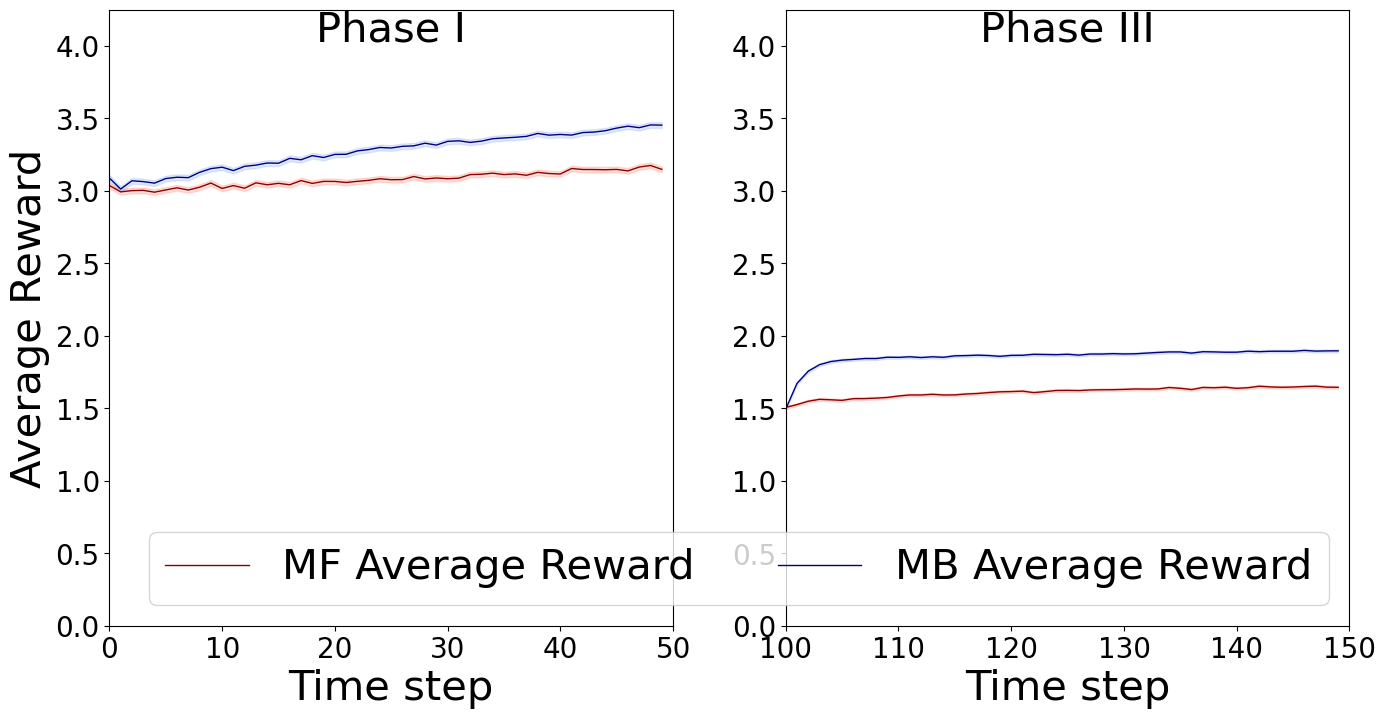

In [18]:
def generate_plot(num_runs, filename):
    all_cumulative_rewards_mf = []
    all_cumulative_rewards_mb = []
    
    # Run simulations
    for i in range(num_runs):
        seed = i  
        cumulative_rewards_mf = run_simulation_mf(seed)
        cumulative_rewards_mb = run_simulation_mb(seed)
        all_cumulative_rewards_mf.append(cumulative_rewards_mf)
        all_cumulative_rewards_mb.append(cumulative_rewards_mb)
    
    # Calculate means and standard errors across runs
    mean_cumulative_rewards_mf = np.mean(all_cumulative_rewards_mf, axis=0)
    stderr_mf = np.std(all_cumulative_rewards_mf, axis=0)
    
    mean_cumulative_rewards_mb = np.mean(all_cumulative_rewards_mb, axis=0)
    stderr_mb = np.std(all_cumulative_rewards_mf, axis=0)
    
    h_mf = 1.96 * (stderr_mf/ np.sqrt(num_runs))
    h_mb = 1.96 * (stderr_mb/ np.sqrt(num_runs))

    mean_cumulative_rewards_mf1 = mean_cumulative_rewards_mf[0:50]
    mean_cumulative_rewards_mb1 = mean_cumulative_rewards_mb[0:50]
    h_mf1 = h_mf[0:50]
    h_mb1 = h_mb[0:50]

    mean_cumulative_rewards_mf3 = mean_cumulative_rewards_mf[100:150]
    mean_cumulative_rewards_mb3 = mean_cumulative_rewards_mb[100:150]
    h_mf3 = h_mf[100:150]
    h_mb3 = h_mb[100:150]

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 8))
    
    # Plotting the mean cumulative rewards with confidence intervals
    x = range(50)
    ax1.plot(x,mean_cumulative_rewards_mf1, '-', lw=1, label='MF Average Reward', color = 'darkred')
    ax1.fill_between(x, mean_cumulative_rewards_mf1 - h_mf1, mean_cumulative_rewards_mf1 + h_mf1, alpha=0.2, color='tomato')
    ax1.plot(x, mean_cumulative_rewards_mb1, '-', lw=1, label='MB Average Reward', color = 'navy')
    ax1.fill_between(x, mean_cumulative_rewards_mb1 - h_mb1, mean_cumulative_rewards_mb1 + h_mb1, alpha=0.2, color='cornflowerblue')
    ax1.set_xlim(0,50)
    ax1.set_ylim(0,4.25)

    x = range(100,150)
    ax2.plot(x,mean_cumulative_rewards_mf3, '-', lw=1, label='MF Average Reward', color = 'darkred')
    ax2.fill_between(x, mean_cumulative_rewards_mf3 - h_mf3, mean_cumulative_rewards_mf3 + h_mf3, alpha=0.2, color='tomato')
    ax2.plot(x, mean_cumulative_rewards_mb3, '-', lw=1, label='MB Average Reward', color = 'navy')
    ax2.fill_between(x, mean_cumulative_rewards_mb3 - h_mb3, mean_cumulative_rewards_mb3 + h_mb3, alpha=0.2, color='cornflowerblue')
    ax2.set_xlim(100,150)
    ax2.set_ylim(0,4.25)
    
    # Adding phase labels
    ax1.text(25, plt.ylim()[1], 'Phase I', horizontalalignment='center', verticalalignment='top', fontsize=30)   
    ax2.text(125, plt.ylim()[1], 'Phase III', horizontalalignment='center', verticalalignment='top', fontsize=30)

    # Adjusting labels and legend
    ax1.set_ylabel('Average Reward', fontsize=30)
    ax1.set_xlabel('Time step', fontsize=30)
    ax1.set_xticks([0,10,20,30,40,50])
    
    ax2.legend(loc='lower right', fontsize=30, ncol=2)
    ax2.set_xlabel('Time step', fontsize=30)
    ax2.set_xticks([100,110,120,130,140,150])

    fig.savefig(filename,dpi=500)
    
generate_plot(10000, f"All_Runs.png")